# Ejercicio 2

## Fuentes de información
* https://www.arrow.com/en/research-and-events/articles/introduction-to-bayer-filters
* https://es.wikipedia.org/wiki/Mosaico_de_Baye
* https://www.whatdigitalcamera.com/technology_guides/bayer-filter-work-60461
* https://es.wikipedia.org/wiki/Interpolaci%C3%B3n_crom%C3%A1tica

## a. Filtro de Bayer

Las cámaras digitales están construidas con una matriz de fotosensores que son capaces de capturar la luz y medir su intensidad. No obstante, no son capaces de medir o distinguir la longitud de onda $\lambda$, es decir, no pueden determinar el color de la luz.

Para solucionar este problema, se coloca por encima de los sensores una matriz de filtros de color, denominada **CFA** (Color Filter Array). Este filtro busca filtrar qué color recibe cada fotosensor. El **filtro de Bayer** es uno de los filtros utilizados en dispositivos modernos para estos propósitos.

El filtro de Bayer fue inventado por Bryce Bayer en 1974. En este filtro, se define un microarreglo conocido como **RGGB**. Esto es, un arreglo de 2x2 píxeles en donde 2 píxeles tienen un filtro verde, 1 píxel tiene un filtro azul y el último pixel tiene un filtro rojo.

<center><img src="../resources/bayer_rggb.jpg"></img></center>

No se puede escapar de la necesidad de asignar a cada píxel un color para garantizar que el fotosensor esté capturando su intensidad. Por otro lado, el sistema de visión del ser humano es más sensible a la luz verde, y por eso se decide asignar el doble de píxeles que a las componentes rojo y azul.

El resultado de este proceso de filtrado provoca que cada píxel esté capturando la intensidad de un único color (rojo, verde o azul) en su posición. Obteniéndose así un **patrón de Bayer**.

<center><img src="../resources/bayer_pattern.png"></img></center>

La imagen capturada en este punto, es incompleta. Esto es porque, cada píxel sólo cuenta con la información (en su posición) de un sólo color. Es necesario, para tener una iamgen completa, conocer las componentes rojo, verde y azul en todos los píxeles.

## b. Demosaicing
Para solucionar el problema, y recuperar la imagen completa a partir del **patrón de Bayer**, se pueden utilizar técnicas de interpolación, que son denominadas particularmente **demosaicing**.

El demosaicing consiste en reconstruir la imagen completa, estimando los colores que no fueron medidos en cada píxel, utilizando la información de los píxeles vecinos. Cómo se combine esta información en el resultado dependerá de los algoritmos. La elección del algoritmo está sujeta a la capacidad de procesamiento, el costo computacional y energético, y la calidad de la imagen deseada.

Entre *algunos* de los algoritmos no adaptativos, encontramos los siguientes esquemas de interpolación.

### Nearest-neighbor interpolation
Este algoritmo reemplaza las componentes que no fueron medidas de un píxel por el valor del píxel más cercano que posea información en esa componente. En caso de que haya dos o más píxeles con esa componente, se selecciona uno de forma aleatoria.

### Bilinear interpolation
El algoritmo de la interpolación bilineal reemplaza la componente no medida de un píxel por una media aritmética realizada a partir de las componentes de los píxeles vecinos que sí poseen información en esa componente de color.

Por otro lado, existen algoritmos que utilizan la correlación espacial o espectral de los píxeles en una imagen, para estimar el mejor candidato para el componente faltante en un píxel. Entre estos, existen algoritmos adaptativos.

## c. Archivos RAW
Realizamos paso a paso el ejercicio de laboratorio que se encuentra en https://cs.brown.edu/courses/csci1290/labs/lab_raw/index.html.

Las cámaras fotográficas permiten exportar las imágenes en un formato crudo, cuya estructura interna depende del tipo de archivo provisto por el fabricante de la cámara. En cualquiera caso, esta información cruda contiene las imágenes en las matrices de filtros de color de Bayer.

In [1]:
from scipy.signal import convolve2d

In [2]:
import matplotlib.pyplot as plt

In [3]:
from PIL import Image

In [4]:
import numpy as np

In [65]:
import matplotlib

In [41]:
import cv2

In [50]:
import math

In [5]:
def wbscalematrix(m, n, wb_scales, align):
    # Makes a white-balance scaling matrix for an image of size m-by-n
    # from the individual RGB white balance scalar multipliers [wb_scales] = [R_scale G_scale B_scale].
    #
    # [align] is string indicating the 2x2 Bayer arrangement: 
    # 'rggb':  
    #    R G 
    #    G B 
    # 'gbrg':
    #    G B
    #    R G
    # 'grbg','bggr' follow as before.
    #
    # 

    # First, for convenience only, we're going to fill the scale matrix
    # with all green pixels. Then, we're going to replace the red and blue 
    # pixels later on with the correct scalars.
    #
    scalematrix = wb_scales[1] * np.ones((m,n)) # Initialize to all green values

    # Fill in the scales for the red and blue pixels across the matrix
    if (align == 'rggb'):
        scalematrix[0::2, 0::2] = wb_scales[0] # r
        scalematrix[1::2, 1::2] = wb_scales[2] # b
    elif (align == 'bggr'):
        scalematrix[1::2, 1::2] = wb_scales[0] # r
        scalematrix[0::2, 0::2] = wb_scales[2] # b
    elif (align == 'grbg'):
        scalematrix[0::2, 1::2] = wb_scales[0] # r
        scalematrix[0::2, 1::2] = wb_scales[2] # b
    elif (align == 'gbrg'):
        scalematrix[1::2, 0::2] = wb_scales[0] # r
        scalematrix[0::2, 1::2] = wb_scales[2] # b
    return scalematrix

In [6]:
def apply_cmatrix(img, cmatrix):
    # Applies color transformation CMATRIX to RGB input IM. 
    # Finds the appropriate weighting of the old color planes to form the new color planes, 
    # equivalent to but much more efficient than applying a matrix transformation to each pixel.
    if (img.shape[2] != 3):
        raise ValueError('Apply cmatrix to RGB image only.')

    r = cmatrix[0,0] * img[:,:,0] + cmatrix[0,1] * img[:,:,1] + cmatrix[0,2] * img[:,:,2]
    g = cmatrix[1,0] * img[:,:,0] + cmatrix[1,1] * img[:,:,1] + cmatrix[1,2] * img[:,:,2]
    b = cmatrix[2,0] * img[:,:,0] + cmatrix[2,1] * img[:,:,1] + cmatrix[2,2] * img[:,:,2]
    corrected = np.stack((r,g,b), axis=2)
    return corrected

In [7]:
def debayering(input):
    # Bilinear Interpolation of the missing pixels
    #
    # Assumes a Bayer CFA in the 'rggb' layout
    #   R G R G
    #   G B G B
    #   R G R G
    #   G B G B
    #
    # Input: Single-channel rggb Bayered image
    # Returns: A debayered 3-channels RGB image
    #
    img = input.astype(np.double)

    m = img.shape[0]
    n = img.shape[1]

    # First, we're going to create indicator masks that tell us
    # where each of the color pixels are in the bayered input image
    # 1 indicates presence of that color, 0 otherwise
    red_mask = np.tile([[1,0],[0,0]], (int(m/2), int(n/2)))
    green_mask = np.tile([[0,1],[1,0]], (int(m/2), int(n/2)))
    blue_mask = np.tile([[0,0],[0,1]], (int(m/2), int(n/2)))

    r = np.multiply(img, red_mask)
    g = np.multiply(img, green_mask)
    b = np.multiply(img, blue_mask)

    # Confirm for yourself: 
    # - What are the patterns of values in the r,g,b images?
    # Sketch them out to help yourself.

    # Next, we're going to fill in the missing values in r,g,b
    # For this, we're going to use filtering - convolution - to implement bilinear interpolation.
    # - We know that convolution allows us to perform a weighted sum
    # - We know _where_ our pixels lie within a grid, and where the missing pixels are
    # - We know filters come in odd sizes

    # Interpolating green:
    filter_g = 0.25 * np.array([[0,1,0],[1,0,1],[0,1,0]])
    missing_g = convolve2d(g, filter_g, 'same')
    g = g + missing_g

    # To conceptualize how this works, let's continue to draw it out on paper.
    # - Sketch the first 5 rows and columns of the g image
    # - Sketch the 3x3 filter and add the numeric weights (they sum to 1)
    # - Sketch the output image

    # Move the filter through the valid region of the image.
    # - What is the output at pixel 1,1 ?  [0-index, remember]
    # - What is the output at pixel 2,1 ?
    # - What is the output at pixel 3,1 ?
    # - What is the output at pixel 1,2 ?
    # - What is the output at pixel 2,2 ?
    # - What is the output at pixel 3,2 ?

    # See how it works? 
    # The filter only produces output if the surrounding pixels match its pattern.
    # When they do, it produces their mean value.

    # Note that we're going to have some incorrect values at the image boundaries, 
    # but let's ignore that for this exercise.

    # Now, let's try it for blue. This one is a two-step process.
    # - Step 1: We fill in the 'central' blue pixel in the location of the red pixel
    # - Step 2: We fill in the blue pixels at the locations of the green pixels, 
    #           similar to how the green interpolation worked, but offset by a row/column
    #
    # Sketch out the matrices to help you follow.
    # Remember, we'll still have some incorrect value at the image boundaries.

    # Interpolating blue:
    # Step 1:
    filter1 = 0.25 * np.array([[1,0,1],[0,0,0],[1,0,1]])
    missing_b1 = convolve2d(b, filter1, 'same')
    # Step 2:
    filter2 = 0.25 * np.array([[0,1,0],[1,0,1],[0,1,0]])
    missing_b2 = convolve2d(b + missing_b1, filter2, 'same')
    b = b + missing_b1 + missing_b2

    # OK! Only red left.

    # Interpolation for the red at the missing points
    # TODO: Complete the following two lines. Follow a similar strategy to the blue channel.
    missing_r1 = convolve2d(r, filter1, 'same')
    missing_r2 = convolve2d(r + missing_r1, filter2, 'same')
    r = r + missing_r1 + missing_r2

    output = np.stack((r,g,b), axis=2)
    return output

Primero, utilizamos el programa **dcraw** para ejecutar una rutina de reconocimiento en la imagen de prueba **sample.DNG**. Como resultado, obtenemos los siguientes valores,

<center>
    <img src="../resources/dcraw_rec_result.png">
    </img>
</center>

In [8]:
# Step 0: Convert RAW file to TIFF
black = 0
saturation = 16383  
wb_multipliers = [2.217041, 1.000000, 1.192484]

# Open the CFA image
raw_data = Image.open('../resources/sample.tiff')
raw = np.array(raw_data).astype(np.double)

En otro paso, se linealiza y normaliza el contenido de los píxeles para utilizar el rango dinámico completo.

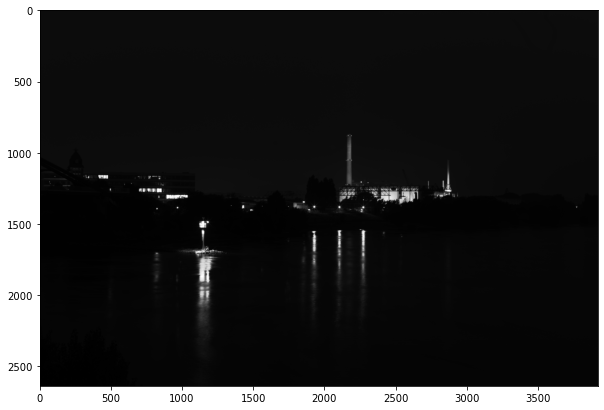

In [9]:
# Step 1: Normalization
linear_bayer = (raw - black) / (saturation - black)

# Plot the CFA image
plt.figure(figsize=(10, 10))
plt.imshow(linear_bayer, cmap='gray')
plt.show()

Se escalan las componentes de color rojo, verde y azul con el objetivo de llevar los colores presentes en la imágen a una escala apropiada tomando como referencia el color blanco. Esto es lo que se conoce como **balance de blancos**.

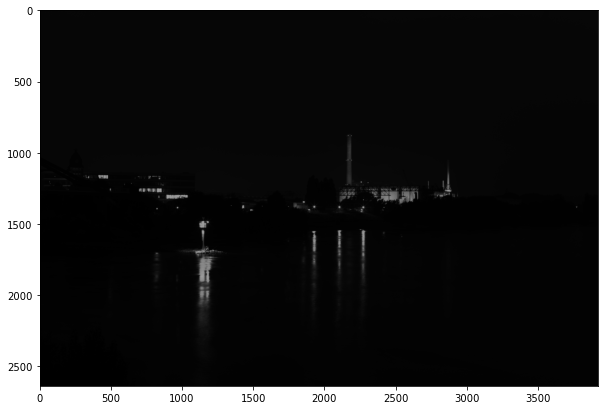

In [10]:
# Step 2: White balancing
mask = wbscalematrix(linear_bayer.shape[0], linear_bayer.shape[1], wb_multipliers, 'rggb')
balanced_bayer = np.multiply(linear_bayer, mask)

# Plot balanced result
plt.figure(figsize=(10, 10))
plt.imshow(balanced_bayer, cmap='gray')
plt.show()

Se aplica el **debayering** o **demosaicing**, esto es, una interpolación para reconstruir las componentes de color rojo, verde y azul que no se encuentran presentes por el filtrado Bayer que aplican las cámaras fotográficas. En este caso, se realizan promediados para reconstruir pixel a pixel estas componentes.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


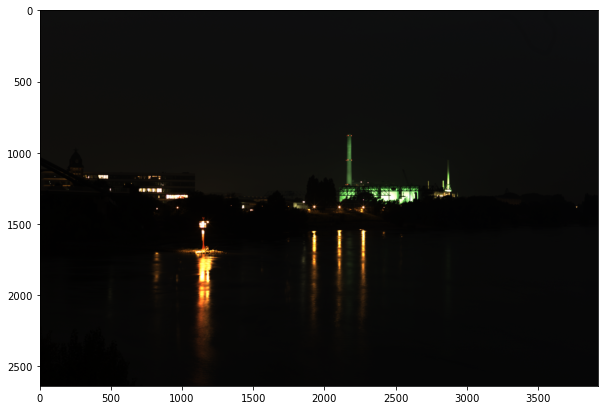

In [104]:
# Step 3: Debayering (also called demosaicing)
lin_rgb = debayering(balanced_bayer)

# Plot the result
plt.figure(figsize=(10, 10))
plt.imshow(lin_rgb)
plt.show()

Se aplica una transformación para llevar los colores a un espacio de color sRGB que puede ser interpretado y representado correctamente por Windows y las computadores modernas.

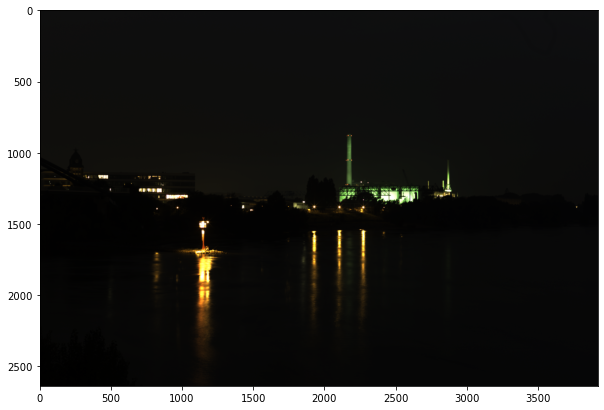

In [107]:
# Step 4: Color space conversion --- we do this one for you.
# Convert to sRGB. xyz2cam is found in dcraw's source file adobe_coeff.
rgb2xyz = np.array([[0.4124564, 0.3575761, 0.1804375],
            [0.2126729, 0.7151522, 0.0721750],
            [0.0193339, 0.1191920, 0.9503041]])
xyz2cam = np.array([[0.6653, -0.1486, -0.0611],
            [-0.4221, 1.3303, 0.0929],
            [-0.0881, 0.2416, 0.7226]])
rgb2cam = xyz2cam * rgb2xyz # Assuming previously defined matrices
denom = np.tile(np.reshape(np.sum(rgb2cam,axis=1),(3,-1)), (1,3))
rgb2cam = np.divide(rgb2cam, denom) # Normalize rows to 1
cam2rgb = np.linalg.inv(rgb2cam)
lin_srgb = apply_cmatrix(lin_rgb, cam2rgb)
lin_srgb[lin_srgb > 1.0] = 1.0 # Always keep image clipped b/w 0-1
lin_srgb[lin_srgb < 0.0] = 0.0

# Plot the results
plt.figure(figsize=(10, 10))
plt.imshow(lin_srgb)
plt.show()

Finalmente, se debe aplicar una corrección de brillo y de gamma.

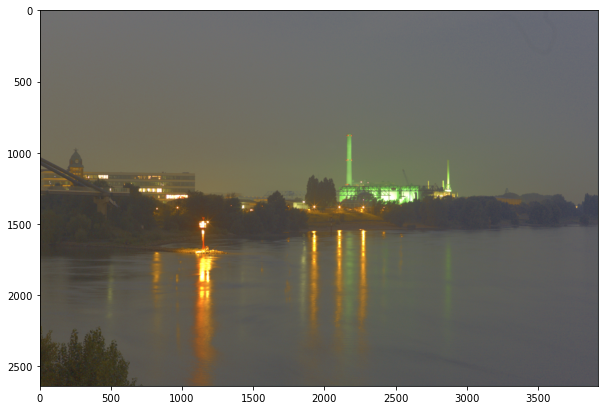

In [194]:
# Step 5: Brightness and gamma correction
gamma_hsv = matplotlib.colors.rgb_to_hsv(lin_srgb)
adjust_brightness = 0.00
magic_touch = 0.05
gamma_hsv[:,:,2] += adjust_brightness
gamma = np.log10(0.5) / np.log10(gamma_hsv[:,:,2].mean()) + magic_touch
gamma_hsv[:,:,2] = np.power(gamma_hsv[:,:,2], gamma)
gamma_srgb = matplotlib.colors.hsv_to_rgb(gamma_hsv)
gamma_srgb[gamma_srgb > 1.0] = 1.0
gamma_srgb[gamma_srgb < 0.0] = 0.0


plt.figure(figsize=(10, 10))
plt.imshow(gamma_srgb)
plt.show()